In [30]:
from google.colab import files
uploaded = files.upload()

Saving names.txt to names (1).txt


In [31]:
words = open('names.txt', 'r').read().splitlines()

In [32]:
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [33]:
len(words)

32033

In [34]:
char = sorted(list(set(''.join(words))))
stoi = { s:i+1 for i,s in enumerate(char)}
stoi['.'] = 0
itos = { i:s for s,i in stoi.items()}

In [64]:
import torch
import torch.nn.functional as F

In [89]:
block_size = 3
X, Y = [],[]
for w in words:
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    context = context[1:] + [ix]
X = torch.tensor(X)
Y = torch.tensor(Y)
#print(X,Y)

In [90]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [42]:
C = torch.randn(27,2)

In [44]:
C[X].shape

torch.Size([32, 3, 2])

In [68]:

W1 = torch.randn(6, 100)
b1 = torch.randn(100)
W2 = torch.randn(100, 27)
b2 = torch.randn(27)


In [69]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)

In [70]:
loss

tensor(13.3478)

In [71]:
#---------- respectable :) ----------------------

In [91]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [92]:
sum(p.nelement() for p in parameters)

3481

In [93]:
for p in parameters:
  p.requires_grad = True

In [107]:
for _ in range(1000):

  #minibatch
  ix = torch.randint(0, X.shape[0], (32,))

  #forwardpass
  emb = C[X[ix]]
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y[ix])
  #backwardpass
  for p in parameters:
    p.grad = None
  loss.backward()
  #update parameters
  for p in parameters:
    p.data += -0.1 * p.grad
print(loss.item())

2.6783204078674316


In [108]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.5289, grad_fn=<NllLossBackward0>)

In [109]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [110]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [111]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [112]:
for p in parameters:
  p.requires_grad = True

In [113]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [114]:
lri = []
lossi = []
stepi = []

In [126]:
for i in range(400000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

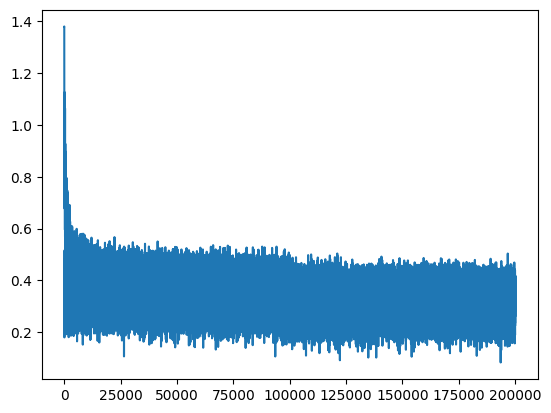

In [122]:
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
plt.plot(stepi, lossi)

In [123]:
# training loss
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0784, grad_fn=<NllLossBackward0>)

In [124]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1342, grad_fn=<NllLossBackward0>)

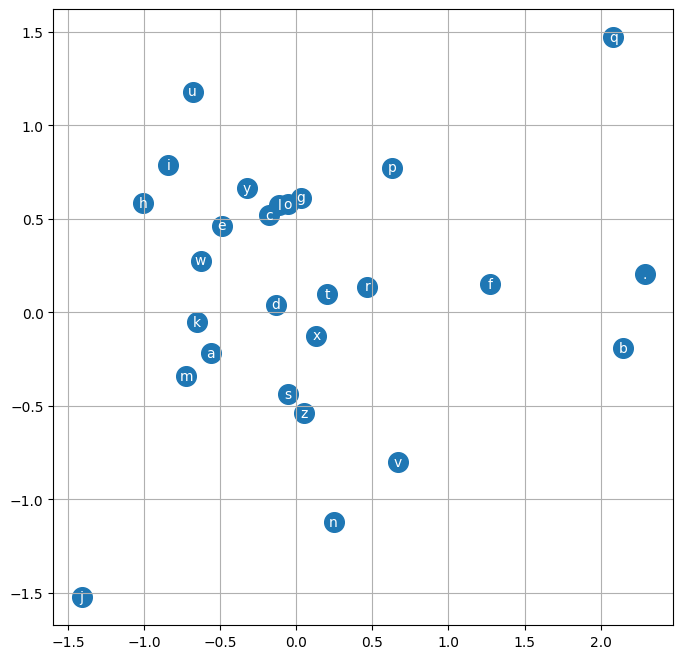

In [125]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [127]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

mora.
mayah.
see.
medhanalee.
threttedrie.
caderronelin.
shi.
jen.
eden.
estanaraylynn.
hones.
noshib.
ridhi.
jest.
jairenleigh.
terian.
breyce.
ryyah.
fael.
yuva.
